# Постановка задачи

Обучить модель для решения задачи Layout Detection на предложенном датасете

# Метод решения:

*   Реализовать собственный класс на основе torch.utils.data.Dataset
*   Имплементировать и обучить модель 
*   Оценить результаты




In [ ]:
# import Google drive with dataset
from google.colab import drive
drive.mount('/content/drive')

In [1]:
!ls /content/drive/My\ Drive/mil_test/dataset

data  test.json  train.json


In [2]:
# add GD directory to PATH
import sys
sys.path.append('/content/drive/My Drive/mil_test/')

In [3]:
# import libs
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)
import cv2
import os
from pycocotools.coco import COCO
import torch
import torchvision
import torch.backends.cudnn as cudnn
import time

В качестве базового решения была выбрана SSD сеть из статьи https://arxiv.org/pdf/1512.02325.pdf

Конкретная реализация сети на pytorch взята отсюда: https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection

Были использованы модули model, utils и eval с некоторыми доработками исходного кода, связанными со спецификой формата датасета.

In [4]:
# import custom class MILDataset and additional modules
from dataset import MILDataset
from model import SSD300, MultiBoxLoss
from utils import *
from eval import *

In [5]:
# path to dataset
dataset_path = '/content/drive/My Drive/mil_test/dataset'

In [7]:
# get look on dataset
train_dataset = MILDataset(root=dataset_path + '/data', annotation=os.path.join(dataset_path, 'train.json'))

loading annotations into memory...
Done (t=0.16s)
creating index...
index created!
COCO categories: 
text figure

COCO supercategories: 



В датасете 2 класса: text, figure

In [8]:
# one example
train_dataset[1]

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=601x792 at 0x7F30BE25F110>,
 {'area': tensor([ 13719.2920,   4911.4111,  29678.8066,  40599.5820,  42020.3711,
          151357.0469]), 'boxes': tensor([[0.0844, 0.6891, 0.4841, 0.7743],
          [0.5136, 0.6892, 0.9132, 0.7169],
          [0.0844, 0.7765, 0.4842, 0.9334],
          [0.5136, 0.7191, 0.9133, 0.9334],
          [0.0844, 0.5338, 0.9132, 0.6518],
          [0.1270, 0.0923, 0.8703, 0.5201]]), 'image_id': tensor([356816]), 'iscrowd': tensor([0, 0, 0, 0, 0, 0]), 'labels': tensor([1, 1, 1, 1, 1, 2])})

In [ ]:
# initialize COCO api for instance annotations
coco=COCO(os.path.join(dataset_path, 'train.json'))

loading annotations into memory...
Done (t=0.15s)
creating index...
index created!


In [ ]:
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['text', 'figure']);
imgIds = coco.getImgIds(catIds=catIds );
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
W = img['width']
H = img['height']

(800, 600, 3)
600 800


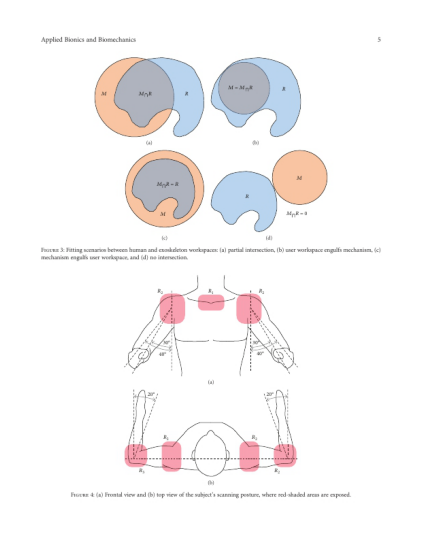

In [ ]:
# use url to load image
I = io.imread(dataset_path + '/data/' + img['file_name'])
print(I.shape)
print(W,H)
plt.axis('off')
plt.imshow(I)
plt.show()

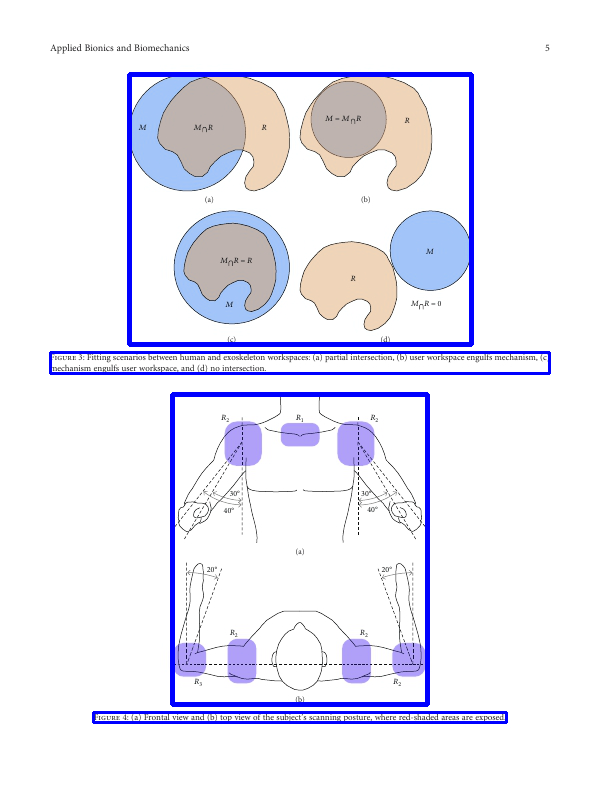

In [ ]:
from google.colab.patches import cv2_imshow
# load and display instance annotations
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)

for i in anns:
    [x,y,w,h] = i['bbox']
    cv2.rectangle(I, (int(x*W), int(y*H)), (int((x+w)*W), int((y+h)*H)), (255,0,0), int(i['category_id']) + 1)
cv2_imshow(I)
plt.show()

Более жирной линией выделены регионы с картинками, менее жирной - текст

In [6]:
# add some transformation of source image
from torchvision import transforms as T

def get_transform(train):
    
    transforms = []
    # random flip
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    # normalization and resize to SSD input shape    
    transforms.extend(
        [
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            T.Resize((300, 300))
        ]
    )
    
    return T.Compose(transforms)

In [7]:
# dataloader params
BATCH_SIZE = 2
NUM_WORKERS = 2

#fix random
random.seed(RND_SEED)
np.random.seed(RND_SEED)
torch.manual_seed(RND_SEED)
torch.cuda.manual_seed(RND_SEED)
torch.backends.cudnn.deterministic = True

In [8]:
# function for batch processing
def collate_fn(batch):
    return tuple(zip(*batch))

In [9]:
# train function

# source: https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection

def train(train_loader, model, criterion, optimizer, epoch):
    """
    One epoch's training.
    :param train_loader: DataLoader for training data
    :param model: model
    :param criterion: MultiBox loss
    :param optimizer: optimizer
    :param epoch: epoch number
    """
    model.train()  # training mode enables dropout

    batch_time = AverageMeter()  # forward prop. + back prop. time
    data_time = AverageMeter()  # data loading time
    losses = AverageMeter()  # loss

    start = time.time()

    # Batches
    for i, (images, annotations) in enumerate(train_loader):
        data_time.update(time.time() - start)

        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        boxes = [item['boxes'] for item in annotations]
        labels = [item['labels'] for item in annotations]
        
        # Move to default device
        images = torch.stack(images).to(device)  # (batch_size (N), 3, 300, 300)
        boxes = [b.to(device) for b in boxes]
        labels = [l.to(device) for l in labels]

        # Forward prop.
        predicted_locs, predicted_scores = model(images)  # (N, 8732, 4), (N, 8732, n_classes)

        # Loss
        loss = criterion(predicted_locs, predicted_scores, boxes, labels)  # scalar

        # Backward prop.
        optimizer.zero_grad()
        loss.backward()

        # Clip gradients, if necessary
        if grad_clip is not None:
            clip_gradient(optimizer, grad_clip)

        # Update model
        optimizer.step()

        losses.update(loss.item(), images.size(0))
        batch_time.update(time.time() - start)

        start = time.time()

        # Print status
        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data Time {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(epoch, i, len(train_loader),
                                                                  batch_time=batch_time,
                                                                  data_time=data_time, loss=losses))
    del predicted_locs, predicted_scores, images, boxes, labels  # free some memory since their histories may be stored


In [9]:
# Model training params

# Source: https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection

# Model parameters
# Not too many here since the SSD300 has a very specific structure
n_classes = 3  # number of different types of objects


# Learning parameters
checkpoint = None  # path to model checkpoint, None if none
batch_size = BATCH_SIZE  # batch size
iterations = 120000  # number of iterations to train
print_freq = 200  # print training status every __ batches
lr = 1e-3  # learning rate
decay_lr_at = [80000, 100000]  # decay learning rate after these many iterations
decay_lr_to = 0.1  # decay learning rate to this fraction of the existing learning rate
momentum = 0.9  # momentum
weight_decay = 5e-4  # weight decay
grad_clip = None  # clip if gradients are exploding, which may happen at larger batch sizes (sometimes at 32) - you will recognize it by a sorting error in the MuliBox loss calculation

cudnn.benchmark = True

In [11]:
# initialise train_dataloader

train_dataset = MILDataset(root=dataset_path + '/data', annotation=os.path.join(dataset_path, 'train.json'), transforms=get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn
    )

loading annotations into memory...
Done (t=0.16s)
creating index...
index created!
COCO categories: 
text figure

COCO supercategories: 



In [ ]:
# Model training

# Source: https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection


global start_epoch, label_map, epoch, checkpoint, decay_lr_at

# Initialize model or load checkpoint
if checkpoint is None:
    start_epoch = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SSD300(n_classes=n_classes)
    # Initialize the optimizer, with twice the default learning rate for biases, as in the original Caffe repo
    biases = list()
    not_biases = list()
    for param_name, param in model.named_parameters():
        if param.requires_grad:
            if param_name.endswith('.bias'):
                biases.append(param)
            else:
                not_biases.append(param)
    optimizer = torch.optim.SGD(params=[{'params': biases, 'lr': 2 * lr}, {'params': not_biases}],
                                lr=lr, momentum=momentum, weight_decay=weight_decay)

else:
    checkpoint = torch.load(checkpoint)
    start_epoch = checkpoint['epoch'] + 1
    print('\nLoaded checkpoint from epoch %d.\n' % start_epoch)
    model = checkpoint['model']
    optimizer = checkpoint['optimizer']

# Move to default device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy).to(device)

# Calculate total number of epochs to train and the epochs to decay learning rate at (i.e. convert iterations to epochs)
# To convert iterations to epochs, divide iterations by the number of iterations per epoch
# The paper trains for 120,000 iterations with a batch size of 32, decays after 80,000 and 100,000 iterations
epochs = iterations // (len(train_dataset) // BATCH_SIZE)
decay_lr_at = [it // (len(train_dataset) // BATCH_SIZE) for it in decay_lr_at]

print(epochs, decay_lr_at)

# Epochs
for epoch in range(start_epoch, epochs):

    # Decay learning rate at particular epochs
    if epoch in decay_lr_at:
        adjust_learning_rate(optimizer, decay_lr_to)

    # One epoch's training
    train(train_loader=data_loader,
            model=model,
            criterion=criterion,
            optimizer=optimizer,
            epoch=epoch)

    # Save checkpoint
    save_checkpoint(epoch, model, optimizer)


Loaded base model.

240 [160, 200]


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch: [0][0/500]	Batch Time 1.099 (1.099)	Data Time 0.954 (0.954)	Loss 14.3549 (14.3549)	
Epoch: [0][200/500]	Batch Time 0.089 (0.417)	Data Time 0.000 (0.330)	Loss 3.0761 (inf)	
Epoch: [0][400/500]	Batch Time 0.091 (0.370)	Data Time 0.000 (0.284)	Loss 4.2338 (inf)	
Epoch: [1][0/500]	Batch Time 0.286 (0.286)	Data Time 0.179 (0.179)	Loss 3.2903 (3.2903)	
Epoch: [1][200/500]	Batch Time 0.095 (0.098)	Data Time 0.006 (0.007)	Loss 3.4607 (inf)	
Epoch: [1][400/500]	Batch Time 0.100 (0.097)	Data Time 0.006 (0.006)	Loss 2.8510 (inf)	
Epoch: [2][0/500]	Batch Time 0.276 (0.276)	Data Time 0.178 (0.178)	Loss 2.9775 (2.9775)	
Epoch: [2][200/500]	Batch Time 0.098 (0.099)	Data Time 0.006 (0.007)	Loss 3.0443 (inf)	
Epoch: [2][400/500]	Batch Time 0.102 (0.099)	Data Time 0.006 (0.006)	Loss 2.3840 (inf)	
Epoch: [3][0/500]	Batch Time 0.394 (0.394)	Data Time 0.303 (0.303)	Loss inf (inf)	
Epoch: [3][200/500]	Batch Time 0.098 (0.102)	Data Time 0.006 (0.008)	Loss 2.4464 (inf)	
Epoch: [3][400/500]	Batch Time 0

In [10]:
# load checkpoint

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = '/content/drive/My Drive/mil_test/checkpoint_ssd300.pth.tar'

# Load model checkpoint that is to be evaluated
checkpoint = torch.load(checkpoint)
model = checkpoint['model']
model = model.to(device)

# Switch to eval mode
model.eval()

SSD300(
  (base): VGGBase(
    (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4_2): Conv2d(512, 512, kernel_size=(3, 3), 

In [11]:
# initialise dataloader for evaluation

# Set train=False in transform function 

train_dataset = MILDataset(root=dataset_path + '/data', annotation=os.path.join(dataset_path, 'train.json'), transforms=get_transform(train=False))
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn
    )

test_dataset = MILDataset(root=dataset_path + '/data', annotation=os.path.join(dataset_path, 'test.json'), transforms=get_transform(train=False))
test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn
    )


loading annotations into memory...
Done (t=0.15s)
creating index...
index created!
COCO categories: 
text figure

COCO supercategories: 

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
COCO categories: 
text figure

COCO supercategories: 



In [14]:
# evaluation
evaluate(train_loader, model)

/content/drive/My Drive/mil_test/model.py:493: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  image_boxes.append(class_decoded_locs[1 - suppress])
/content/drive/My Drive/mil_test/model.py:495: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  image_scores.append(class_scores[1 - suppress])


{'figure': 0.0, 'text': 0.0}

Mean Average Precision (mAP): 0.000


И здесь нас поджидает неожиданность - mAP равное нулю.

Изучив предыдущий код становится ясно, что была допущена ошибка при применении трансформаций - координаты bbox необходимо также трансформировать.

Для этого можно использовать библиотеку
https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
которая позволяет встраивать в пайплайн аугментаций соответствующие преобразования bbox-ов